Written By: Ananta Faadillah Sophan

# Rossman Store Sales Forecasting

## Problem Statement



*   For companies to become competitive and skyrocket their growth, they need to leverage AI/ML to develop predictive models to forecast sales in the future.
*   Predictive models attempt at forecasting future sales based on historical data while considering seasonality effects, demand, holidays, promotions, and competition.

In this project, the sales team provided the data from 1115 stores. The objective is to predict future daily sales based on the features.






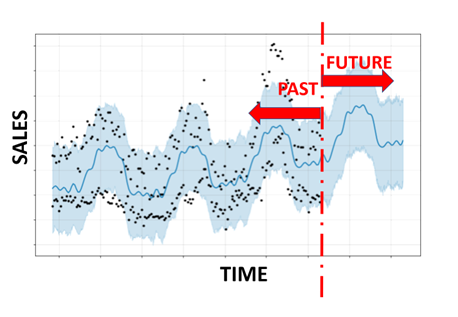

## Data Description

| Column Name   | Description                                                                       |
|---------------|-----------------------------------------------------------------------------------|
| Store         | Unique store ID                                                                   |
| DayOfWeek     | Indicates the day of the sales (1 = Monday, ..., 7 = Sunday)                      |
| Date          | Indicates the date of the sales                                                   |
| Sales         | Sales per day                                                                     |
| Customers     | Number of customers on a given day                                                |
| Open          | Boolean to indicate whether a store is open or closed (0 = Closed, 1 = Open)       |
| Promo         | Boolean that describes if the store is running a promo on that day (0 = No, 1 = Yes) |
| StateHoliday  | Indicates which state Holiday (a = Public holiday, b = Easter holiday, c = Christmas Holiday, 0 = None) |
| SchoolHoliday | Indicates if the (Store, Date) was affected by the closure of public schools       |


| Column Name           | Description                                                                                          |
|-----------------------|------------------------------------------------------------------------------------------------------|
| StoreType             | Differentiates between 4 different store models: a, b, c, d                                       |
| Assortment            | Describes an assortment level: a = basic, b = extra, c = extended                                  |
| CompetitionDistance   | Distance in meters to the nearest competitor store                                                  |
| CompetitionOpenSince[Month/Year] | Gives the approximate year and month of the time the nearest competitor store was opened       |
| Promo2                | Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating |
| Promo2Since[Year/Week]| Describes the year and calendar week when the store started participating in Promo2             |
| PromoInterval         | Describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew (e.g. "Feb,May,Aug,Nov") |
                                                                           


## Import Library

In [1]:
!pip install prophet
from prophet import Prophet
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
import datetime
import calendar
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Data Loading**

### 1.1 The Store Data

In [3]:
store = pd.read_csv('/content/drive/My Drive/Real_Case_Project/Dataset/store.csv')

In [4]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
store.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [6]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [7]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

The CompetitionDistance column has 3 null values. This means that for 3 stores, the competition distance is not known. The CompetitionOpenSinceMonth and CompetitionOpenSinceYear columns have 354 null values each. This means that for 354 stores, the month and year that the nearest competitor opened is not known. The Promo2 column has 0 null values. This means that all stores have a Promo2 value. The Promo2SinceWeek and Promo2SinceYear columns have 544 null values each. This means that for 544 stores, the week and year that Promo2 started is not known. The PromoInterval column has 544 null values. This means that for 544 stores, the interval between Promo2 promotions is not known.

### 1.2 Sales Data

In [8]:
sales = pd.read_csv('/content/drive/My Drive/Real_Case_Project/Dataset/sales.csv')

<ipython-input-8-7c469e216c08>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  sales = pd.read_csv('/content/drive/My Drive/Real_Case_Project/Dataset/sales.csv')


In [9]:
sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [10]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [11]:
sales.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [12]:
sales.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

This is good news, because it means that we can start forecasting without having to worry about handling null values. However, it is still important to inspect the data carefully to make sure that there are no other problems. For example, we should check that there are no outliers.

### 1.3 Data Overview

In [13]:
print(sales.describe().apply(lambda x: x.round()).T)
print('='*100)
print(store.describe().apply(lambda x: x.round()).T)

                   count    mean     std  min     25%     50%     75%      max
Store          1017209.0   558.0   322.0  1.0   280.0   558.0   838.0   1115.0
DayOfWeek      1017209.0     4.0     2.0  1.0     2.0     4.0     6.0      7.0
Sales          1017209.0  5774.0  3850.0  0.0  3727.0  5744.0  7856.0  41551.0
Customers      1017209.0   633.0   464.0  0.0   405.0   609.0   837.0   7388.0
Open           1017209.0     1.0     0.0  0.0     1.0     1.0     1.0      1.0
Promo          1017209.0     0.0     0.0  0.0     0.0     0.0     1.0      1.0
SchoolHoliday  1017209.0     0.0     0.0  0.0     0.0     0.0     0.0      1.0
                            count    mean     std     min     25%     50%  \
Store                      1115.0   558.0   322.0     1.0   280.0   558.0   
CompetitionDistance        1112.0  5405.0  7663.0    20.0   718.0  2325.0   
CompetitionOpenSinceMonth   761.0     7.0     3.0     1.0     4.0     8.0   
CompetitionOpenSinceYear    761.0  2009.0     6.0  1900.0  2

For the `sales` DataFrame:

- **Store:** The data contains records from 1,115 stores, with store numbers ranging from 1 to 1,115.
- **DayOfWeek:** The data includes sales data for each day of the week (1 to 7).
- **Sales:** The average daily sales across all stores is approximately 5,774, with a standard deviation of 3,850. The minimum recorded sales value is 0, while the maximum is 41,551.
- **Customers:** The average number of customers per day across all stores is around 633, with a standard deviation of 464. The minimum number of customers recorded is 0, while the maximum is 7,388.
- **Open:** The 'Open' column indicates whether a store was open (1) or closed (0). The data shows that all stores were mostly open during the recorded period.
- **Promo:** The 'Promo' column represents whether a store was running a promotion (1) or not (0). The data indicates that promotions were mostly not running during the recorded period.
- **SchoolHoliday:** The 'SchoolHoliday' column indicates whether a school holiday was active (1) or not (0). The data suggests that most of the time, school holidays were not active.

For the `store` DataFrame:

- **Store:** The data contains records from 1,115 stores, with store numbers ranging from 1 to 1,115, consistent with the `sales` DataFrame.
- **CompetitionDistance:** This column represents the distance to the nearest competitor store for each store. The average competition distance is approximately 5,405, with a standard deviation of 7,663. The minimum recorded distance is 20, while the maximum is 75,860.
- **CompetitionOpenSinceMonth:** This column indicates the month when the nearest competitor store opened. However, not all stores have this information, as shown by the count (761) being less than the total number of stores (1,115).
- **CompetitionOpenSinceYear:** This column indicates the year when the nearest competitor store opened. Like the previous column, not all stores have this information.
- **Promo2:** The 'Promo2' column represents whether a store was participating in a continuing promotion (1) or not (0). The data suggests that most stores were participating in Promo2.
- **Promo2SinceWeek:** This column indicates the week since which Promo2 has been running for stores that participate in it. Again, not all stores have this information, as indicated by the count (571).
- **Promo2SinceYear:** This column indicates the year since which Promo2 has been running for participating stores. Like the previous column, not all stores have this information.

Overall, giving insight into the range and distribution of the data for each column is important, but Keep in mind that any missing values in certain columns indicate that the corresponding information was not available for all stores.


## **2. Data Cleaning**

### 2.1 The Store Data

In [14]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

#### 2.1.1 CompetitionDistance Columns

In [15]:
store[store['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [16]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean(), inplace = True)

In [17]:
store['CompetitionDistance'] = store['CompetitionDistance'].astype(int)

In [18]:
store.loc[[290, 621, 878]]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,5404,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,5404,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,5404,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


#### 2.1.2 Competitor Information Columns

In [19]:
store[store['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870,NaN,NaN,0,NaN,NaN,NaN


In [20]:
store[store['CompetitionOpenSinceMonth'].isnull() & store['CompetitionOpenSinceYear'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870,NaN,NaN,0,NaN,NaN,NaN


In [21]:
cols = ['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']

for i in cols:
    store[i].fillna(0, inplace = True)

In [22]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

#### 2.1.3 Promo Information Columns

In [23]:
store[store['Promo2']== 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260,0.0,0.0,0,NaN,NaN,NaN


In [24]:
store[store['Promo2']== 0 & store['Promo2SinceWeek'].isnull() & store['Promo2SinceYear'].isnull() & store['PromoInterval'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260,0.0,0.0,0,NaN,NaN,NaN


In [25]:
cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

for i in cols:
    store[i].fillna(0, inplace = True)

#### 2.1.4 Final Store Data

In [26]:
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [27]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   int64  
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 87.2+ KB


In [28]:
store[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
       'Promo2SinceWeek', 'Promo2SinceYear']] = store[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']].astype(int)

In [29]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Store                      1115 non-null   int64 
 1   StoreType                  1115 non-null   object
 2   Assortment                 1115 non-null   object
 3   CompetitionDistance        1115 non-null   int64 
 4   CompetitionOpenSinceMonth  1115 non-null   int64 
 5   CompetitionOpenSinceYear   1115 non-null   int64 
 6   Promo2                     1115 non-null   int64 
 7   Promo2SinceWeek            1115 non-null   int64 
 8   Promo2SinceYear            1115 non-null   int64 
 9   PromoInterval              1115 non-null   object
dtypes: int64(7), object(3)
memory usage: 87.2+ KB


In [30]:
store[store.duplicated()].shape

(0, 10)

### 2.2 The Sales Data

In [31]:
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [32]:
sales[sales.duplicated()].shape

(0, 9)

In [33]:
print('Total Store in Sales:', len(sales))
print('0 : Close\n'
      '1 : Open')
print(sales['Open'].value_counts())


Total Store in Sales: 1017209
0 : Close
1 : Open
1    844392
0    172817
Name: Open, dtype: int64


In [34]:
sales_raw = sales.copy()

In [35]:
sales = sales.query("Open == 1")

In [36]:
sales.drop('Open', axis = 1 , inplace = True)

<ipython-input-36-9007ecde31b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales.drop('Open', axis = 1 , inplace = True)


In [37]:
salesclose = sales_raw.query("Open == 0")

## **3. Exploratory Data Analysis**

###3.1 Descriptive Statistics Comparison

In [38]:
sales_describe = pd.DataFrame(sales.describe())
sales_raw_describe = pd.DataFrame(sales_raw.describe())

print('='*40 ,'COMPARISON', '='*40)
data = {
  "=": ['='],}
boundaries = pd.DataFrame(data)

combined_df = pd.concat([sales_raw_describe, boundaries, sales_describe])

combined_df.fillna('=')

======================================== COMPARISON ========================================


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,=
count,1017209.0,1017209.0,1017209.0,1017209.0,1017209.0,1017209.0,1017209.0,=
mean,558.429727,3.998341,5773.818972,633.145946,0.830107,0.381515,0.178647,=
std,321.908651,1.997391,3849.926175,464.411734,0.375539,0.485759,0.383056,=
min,1.0,1.0,0.0,0.0,0.0,0.0,0.0,=
25%,280.0,2.0,3727.0,405.0,1.0,0.0,0.0,=
50%,558.0,4.0,5744.0,609.0,1.0,0.0,0.0,=
75%,838.0,6.0,7856.0,837.0,1.0,1.0,0.0,=
max,1115.0,7.0,41551.0,7388.0,1.0,1.0,1.0,=
0,=,=,=,=,=,=,=,=
count,844392.0,844392.0,844392.0,844392.0,=,844392.0,844392.0,=


In [39]:
sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1


### 3.2 Data Distribution

#### 3.2.1 The Sales Data

array([[<Axes: title={'center': 'Store'}>,
        <Axes: title={'center': 'DayOfWeek'}>],
       [<Axes: title={'center': 'Sales'}>,
        <Axes: title={'center': 'Customers'}>],
       [<Axes: title={'center': 'Promo'}>,
        <Axes: title={'center': 'SchoolHoliday'}>]], dtype=object)

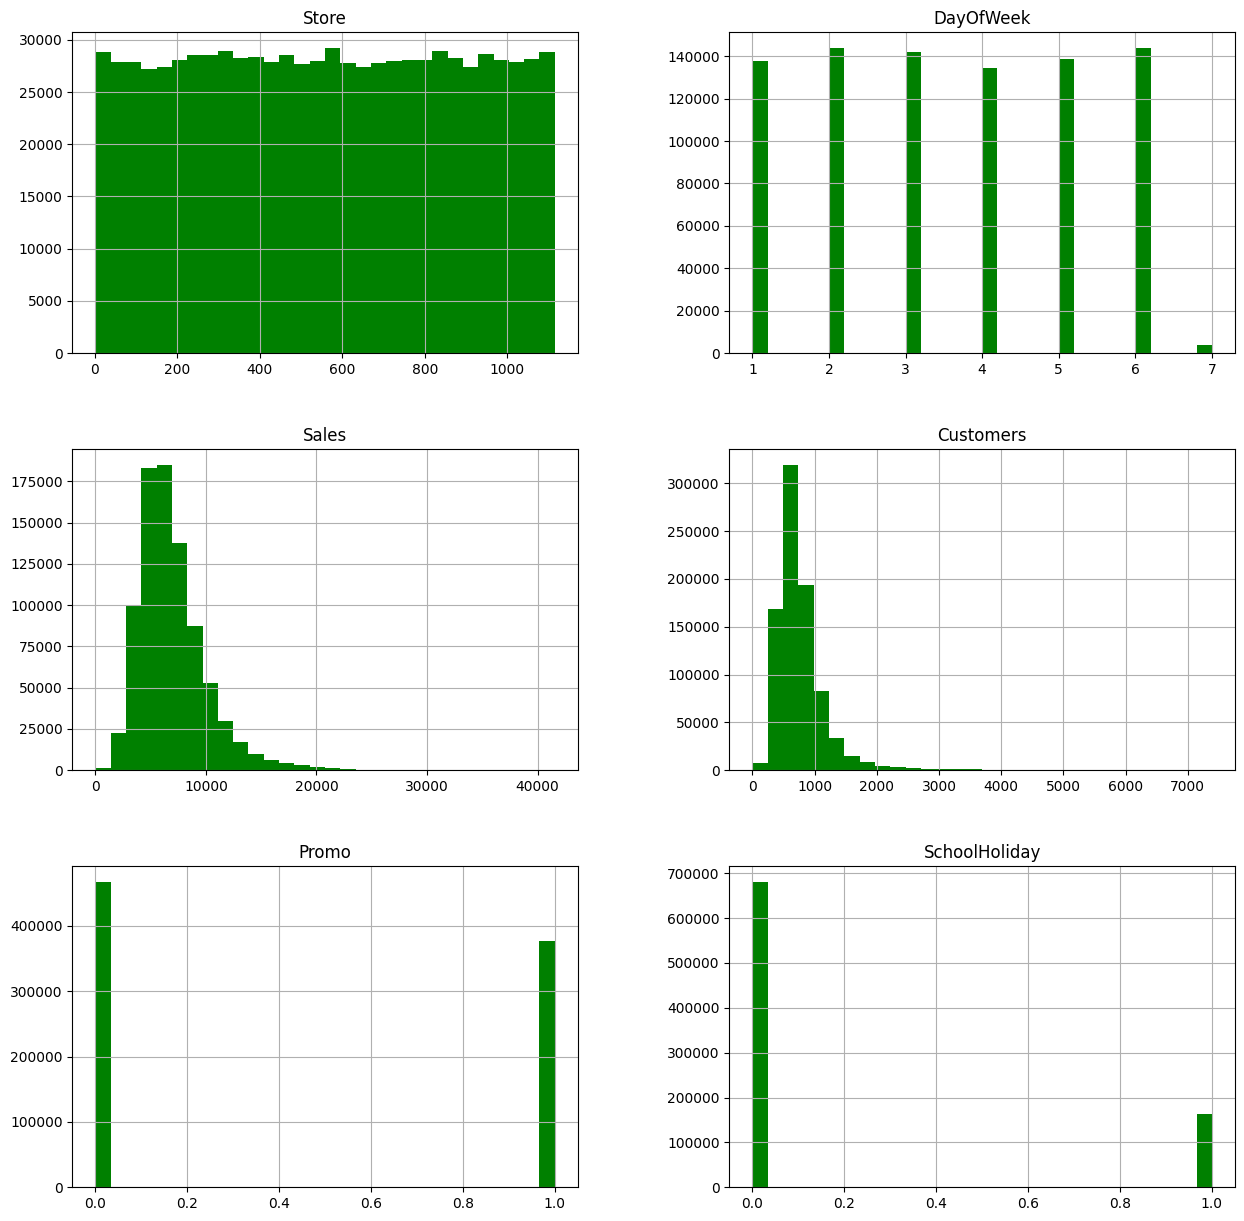

In [40]:
sales.hist(bins=30, figsize=(15,15),color='g')

#### 3.2.2 The Store Data

array([[<Axes: title={'center': 'Store'}>,
        <Axes: title={'center': 'CompetitionDistance'}>,
        <Axes: title={'center': 'CompetitionOpenSinceMonth'}>],
       [<Axes: title={'center': 'CompetitionOpenSinceYear'}>,
        <Axes: title={'center': 'Promo2'}>,
        <Axes: title={'center': 'Promo2SinceWeek'}>],
       [<Axes: title={'center': 'Promo2SinceYear'}>, <Axes: >, <Axes: >]],
      dtype=object)

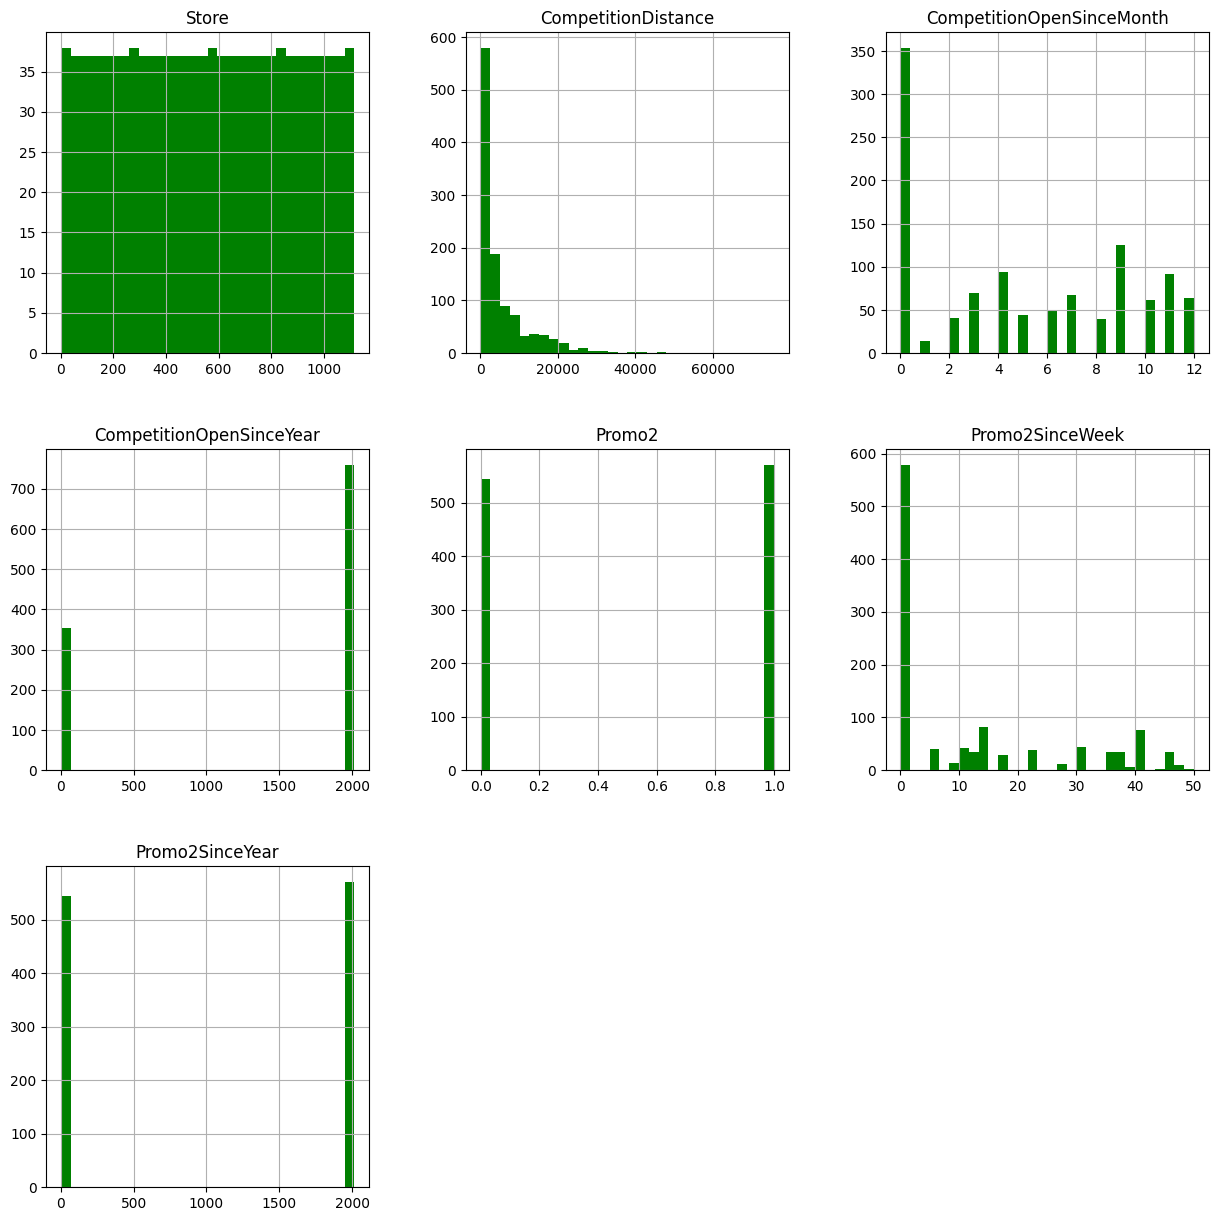

In [41]:
store.hist(bins=30, figsize=(15,15),color='g')

### 3.3 Merged Data (Store and Sales Data)

In [42]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Store          844392 non-null  int64 
 1   DayOfWeek      844392 non-null  int64 
 2   Date           844392 non-null  object
 3   Sales          844392 non-null  int64 
 4   Customers      844392 non-null  int64 
 5   Promo          844392 non-null  int64 
 6   StateHoliday   844392 non-null  object
 7   SchoolHoliday  844392 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 58.0+ MB


In [43]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Store                      1115 non-null   int64 
 1   StoreType                  1115 non-null   object
 2   Assortment                 1115 non-null   object
 3   CompetitionDistance        1115 non-null   int64 
 4   CompetitionOpenSinceMonth  1115 non-null   int64 
 5   CompetitionOpenSinceYear   1115 non-null   int64 
 6   Promo2                     1115 non-null   int64 
 7   Promo2SinceWeek            1115 non-null   int64 
 8   Promo2SinceYear            1115 non-null   int64 
 9   PromoInterval              1115 non-null   object
dtypes: int64(7), object(3)
memory usage: 87.2+ KB


#### 3.3.1 Adding UPT (Unit Per Transaction)

In [44]:
(sales['Customers'] >= sales['Sales']).value_counts()

False    844338
True         54
dtype: int64

In [45]:
sales[(sales['Customers'] >= sales['Sales'])]

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
86825,971,5,2015-05-15,0,0,0,0,1
142278,674,4,2015-03-26,0,0,0,0,0
196938,699,4,2015-02-05,0,0,1,0,0
322053,708,3,2014-10-01,0,0,1,0,0
330176,357,1,2014-09-22,0,0,0,0,0
340348,227,4,2014-09-11,0,0,0,0,0
340860,835,4,2014-09-11,0,0,0,0,0
341795,835,3,2014-09-10,0,0,0,0,0
346232,548,5,2014-09-05,0,0,1,0,1
346734,28,4,2014-09-04,0,0,1,0,0


In [46]:
sales[(sales['Customers'] >= sales['Sales']) & sales['Customers']>0]

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
478649,1100,2,2014-04-29,0,3,1,0,0
889932,948,4,2013-04-25,0,5,1,0,0


In [47]:
sales['UPT'] = sales['Sales'] / sales['Customers']

In [48]:
sales[sales['UPT'].isnull()]

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,UPT
86825,971,5,2015-05-15,0,0,0,0,1,NaN
142278,674,4,2015-03-26,0,0,0,0,0,NaN
196938,699,4,2015-02-05,0,0,1,0,0,NaN
322053,708,3,2014-10-01,0,0,1,0,0,NaN
330176,357,1,2014-09-22,0,0,0,0,0,NaN
340348,227,4,2014-09-11,0,0,0,0,0,NaN
340860,835,4,2014-09-11,0,0,0,0,0,NaN
341795,835,3,2014-09-10,0,0,0,0,0,NaN
346232,548,5,2014-09-05,0,0,1,0,1,NaN
346734,28,4,2014-09-04,0,0,1,0,0,NaN


In [49]:
sales['UPT'].fillna(0, inplace = True)
sales['UPT'].isnull().sum()

0

#### 3.3.2 Extracting the Date

In [50]:
sales['Date'] = pd.to_datetime(sales['Date'])
sales['Year'] = pd.DatetimeIndex(sales['Date']).year
sales['Month'] = pd.DatetimeIndex(sales['Date']).month
sales['Week'] = pd.DatetimeIndex(sales['Date']).week
sales['Day'] = pd.DatetimeIndex(sales['Date']).day

<ipython-input-50-5ae91699db98>:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  sales['Week'] = pd.DatetimeIndex(sales['Date']).week


In [51]:
sales['UPT'] = sales['UPT'].round(0).astype(int)

In [52]:
sales.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,UPT,Year,Month,Week,Day
0,1,5,2015-07-31,5263,555,1,0,1,9,2015,7,31,31


In [53]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Store          844392 non-null  int64         
 1   DayOfWeek      844392 non-null  int64         
 2   Date           844392 non-null  datetime64[ns]
 3   Sales          844392 non-null  int64         
 4   Customers      844392 non-null  int64         
 5   Promo          844392 non-null  int64         
 6   StateHoliday   844392 non-null  object        
 7   SchoolHoliday  844392 non-null  int64         
 8   UPT            844392 non-null  int64         
 9   Year           844392 non-null  int64         
 10  Month          844392 non-null  int64         
 11  Week           844392 non-null  int64         
 12  Day            844392 non-null  int64         
dtypes: datetime64[ns](1), int64(11), object(1)
memory usage: 90.2+ MB


#### 3.3.3 Merge the Data

In [54]:
df = pd.merge(sales, store, how='inner', on = 'Store')

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Promo                      844392 non-null  int64         
 6   StateHoliday               844392 non-null  object        
 7   SchoolHoliday              844392 non-null  int64         
 8   UPT                        844392 non-null  int64         
 9   Year                       844392 non-null  int64         
 10  Month                      844392 non-null  int64         
 11  Week                       844392 non-null  int64   

In [56]:
df.sort_values(by="Date", inplace=True)

In [57]:
df.reset_index(drop=True, inplace=True)

In [58]:
df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,UPT,Year,...,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,353,2,2013-01-01,3139,820,0,a,1,4,2013,...,1,b,b,900,0,0,1,14,2013,"Feb,May,Aug,Nov"
1,676,2,2013-01-01,3821,777,0,a,1,5,2013,...,1,b,b,1410,9,2008,0,0,0,0
2,274,2,2013-01-01,3102,729,0,a,1,4,2013,...,1,b,b,3640,0,0,1,10,2013,"Jan,Apr,Jul,Oct"
3,262,2,2013-01-01,17267,2875,0,a,1,6,2013,...,1,b,a,1180,5,2013,0,0,0,0
4,512,2,2013-01-01,2646,625,0,a,1,4,2013,...,1,b,b,590,0,0,1,5,2013,"Mar,Jun,Sept,Dec"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,844,5,2015-07-31,6444,583,1,0,1,11,2015,...,31,a,a,2030,9,2012,1,18,2011,"Feb,May,Aug,Nov"
844388,630,5,2015-07-31,7544,801,1,0,1,9,2015,...,31,a,a,1690,4,2015,0,0,0,0
844389,429,5,2015-07-31,6999,523,1,0,0,13,2015,...,31,d,c,16350,7,2005,1,31,2013,"Jan,Apr,Jul,Oct"
844390,232,5,2015-07-31,5738,469,1,0,1,12,2015,...,31,c,c,13570,5,2010,1,10,2013,"Mar,Jun,Sept,Dec"


In [59]:
df['Year'].value_counts()

2013    337943
2014    310417
2015    196032
Name: Year, dtype: int64

In [60]:
df13 = df[df['Year']==2013]
df14 = df[df['Year']==2014]
df15 = df[df['Year']==2015]

In [61]:
print('Month in 2013',df13['Month'].unique())
print('Month in 2014',df14['Month'].unique())
print('Month in 2015',df15['Month'].unique())

Month in 2013 [ 1  2  3  4  5  6  7  8  9 10 11 12]
Month in 2014 [ 1  2  3  4  5  6  7  8  9 10 11 12]
Month in 2015 [1 2 3 4 5 6 7]


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844392 entries, 0 to 844391
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Promo                      844392 non-null  int64         
 6   StateHoliday               844392 non-null  object        
 7   SchoolHoliday              844392 non-null  int64         
 8   UPT                        844392 non-null  int64         
 9   Year                       844392 non-null  int64         
 10  Month                      844392 non-null  int64         
 11  Week                       844392 non-null  int64   

### 3.4 Features Correlation

<ipython-input-63-0ea35cf4961e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()


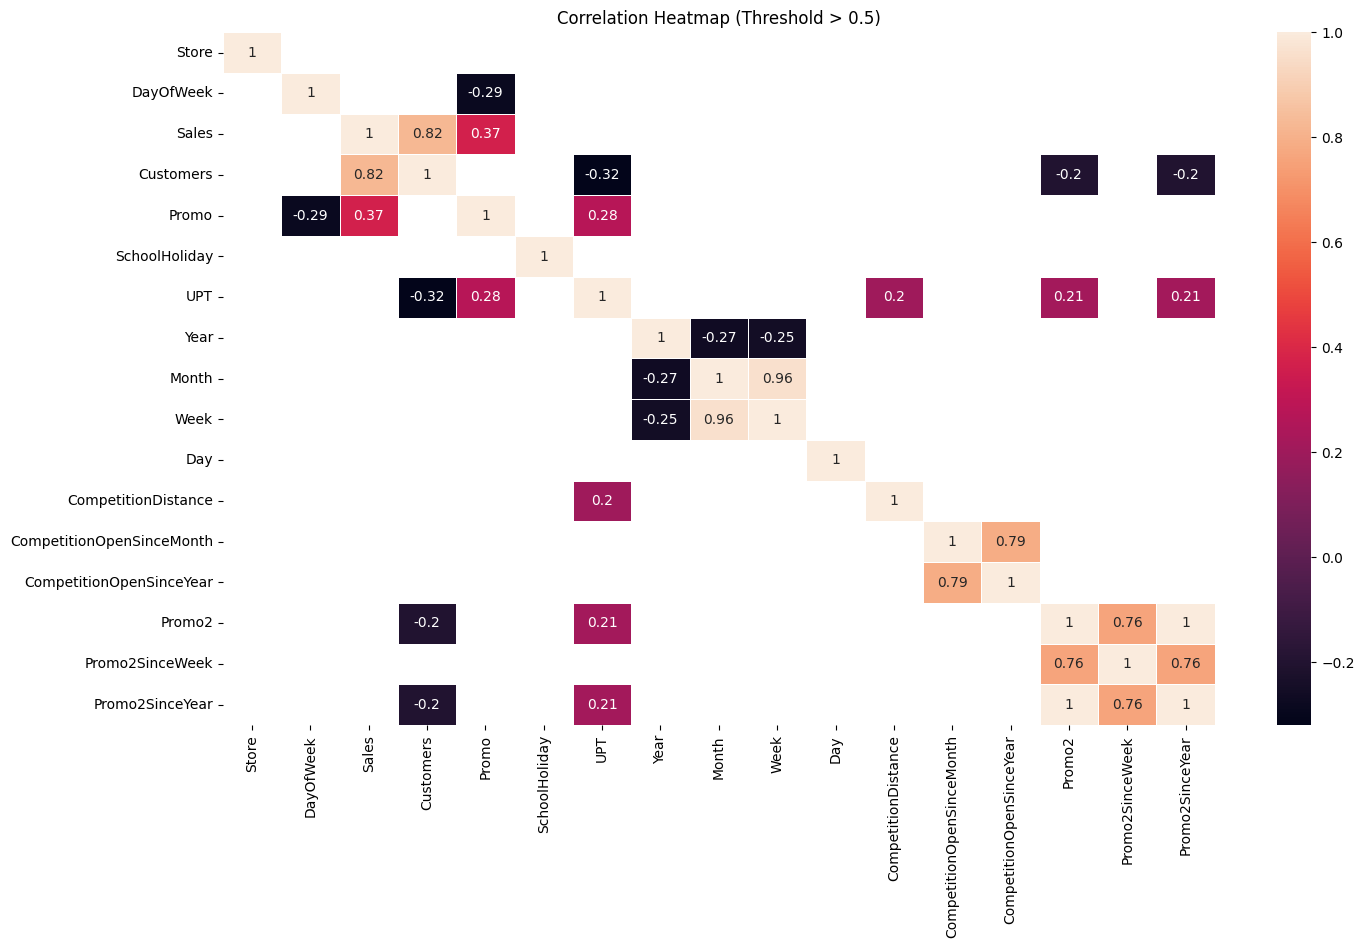

In [63]:
threshold = 0.2
correlations = df.corr()
corr_threshold = correlations[(correlations > threshold) | (correlations < -threshold)]


f, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(corr_threshold, annot=True, linewidths=0.5)

plt.title('Correlation Heatmap (Threshold > 0.5)')
plt.show()


In [64]:
sales_corr = df.corr()['Sales']
sales_corr.sort_values(ascending = False)

<ipython-input-64-f0c3ef0f5978>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sales_corr = df.corr()['Sales']


Sales                        1.000000
Customers                    0.823597
Promo                        0.368145
UPT                          0.185523
Week                         0.074472
Month                        0.073600
SchoolHoliday                0.038617
Year                         0.036169
Store                        0.007710
CompetitionOpenSinceYear     0.005266
CompetitionOpenSinceMonth   -0.018370
CompetitionDistance         -0.036343
Day                         -0.051849
Promo2SinceWeek             -0.058476
Promo2                      -0.127596
Promo2SinceYear             -0.127621
DayOfWeek                   -0.178736
Name: Sales, dtype: float64

In [65]:
customer_corr = df.corr()['Customers']
customer_corr.sort_values(ascending = False)

<ipython-input-65-6ee90858b05e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  customer_corr = df.corr()['Customers']


Customers                    1.000000
Sales                        0.823597
Promo                        0.182846
Month                        0.053856
Week                         0.053774
Store                        0.033977
SchoolHoliday                0.024902
CompetitionOpenSinceYear     0.001666
Year                        -0.000822
CompetitionOpenSinceMonth   -0.021006
Day                         -0.035405
DayOfWeek                   -0.097266
Promo2SinceWeek             -0.130841
CompetitionDistance         -0.148362
Promo2SinceYear             -0.202204
Promo2                      -0.202232
UPT                         -0.320417
Name: Customers, dtype: float64

### 3.5 Data Exploration

In [66]:
df_eda = df[df['Year']<2015]

In [67]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648360 entries, 0 to 648359
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      648360 non-null  int64         
 1   DayOfWeek                  648360 non-null  int64         
 2   Date                       648360 non-null  datetime64[ns]
 3   Sales                      648360 non-null  int64         
 4   Customers                  648360 non-null  int64         
 5   Promo                      648360 non-null  int64         
 6   StateHoliday               648360 non-null  object        
 7   SchoolHoliday              648360 non-null  int64         
 8   UPT                        648360 non-null  int64         
 9   Year                       648360 non-null  int64         
 10  Month                      648360 non-null  int64         
 11  Week                       648360 non-null  int64   

#### 3.5.1 Monthly Report

In [68]:
monthly_avg = pd.pivot_table(df_eda, index='Month', values=['Sales', 'Customers'], aggfunc='mean').reset_index()
monthly_avg['Customers']= monthly_avg['Customers'].round(0).astype(int)
monthly_avg

,Month,Customers,Sales
0,1,717,6389.110698
1,2,733,6553.574538
2,3,764,6927.947680
3,4,771,6897.379726
4,5,779,7010.020102
5,6,758,6846.331727
6,7,761,6908.727396
7,8,750,6648.984654
8,9,746,6546.343035
9,10,753,6602.843354


In [69]:
col = ['Sales', 'Customers']

for i in monthly_avg[col]:
  fig = px.line(monthly_avg, x='Month', y=i, title=f'Monthly {i} Average')
  fig.update_xaxes(tickvals=list(range(1, 13)))
  fig.show()


#### 3.5.2 DayofWeek Report

In [70]:
DayofWeek_avg = pd.pivot_table(df_eda, index='DayOfWeek', values=['Sales', 'Customers'], aggfunc='mean').reset_index()
DayofWeek_avg['Customers']= DayofWeek_avg['Customers'].round(0).astype(int)
DayofWeek_avg

,DayOfWeek,Customers,Sales
0,1,861,8188.729474
1,2,772,7034.124488
2,3,741,6665.721238
3,4,758,6723.644748
4,5,787,7060.942263
5,6,662,5826.984118
6,7,1430,8084.927463


In [71]:
col = ['Sales', 'Customers']

for i in DayofWeek_avg[col]:
  fig = px.line(DayofWeek_avg, x='DayOfWeek', y=i, title=f'Day per Day {i} Average')
  fig.show()


#### 3.5.3 Yearly Report

In [72]:
Yearly_avg = pd.pivot_table(df_eda, index='Year', values=['Sales', 'Customers'], aggfunc='mean').reset_index()
Yearly_avg['Customers']= Yearly_avg['Customers'].round(0).astype(int)
Yearly_avg

,Year,Customers,Sales
0,2013,758,6814.392025
1,2014,775,7025.404201


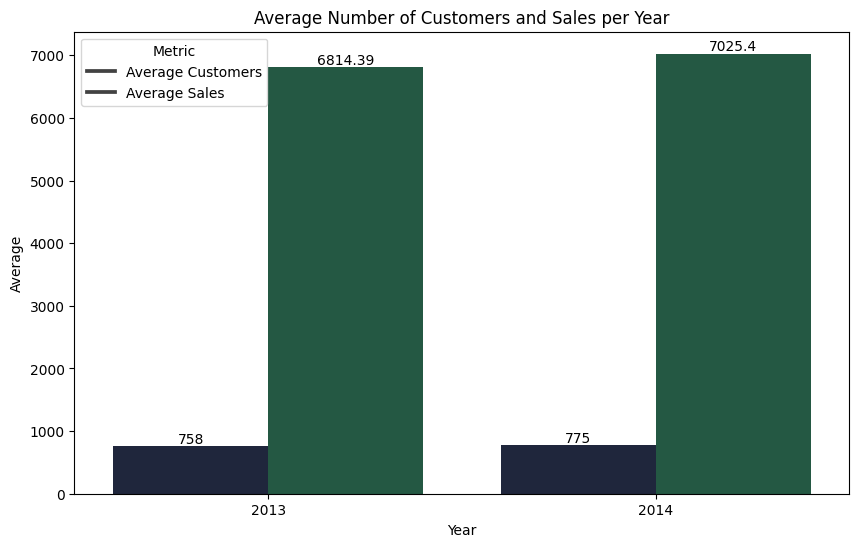

In [73]:
melted_data = pd.melt(Yearly_avg, id_vars='Year', var_name='Metric', value_name='Average')

plt.figure(figsize=(10, 6))
sns.set_palette("cubehelix")
ax = sns.barplot(data=melted_data, x='Year', y='Average', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, label_type='edge')
plt.xlabel('Year')
plt.ylabel('Average')
plt.title('Average Number of Customers and Sales per Year')
plt.legend(title='Metric', loc='upper left', labels=['Average Customers', 'Average Sales'])
plt.show()

#### 3.5.4 Does the presence of promotions or holiday affect the increase in sales?

##### 3.5.4.1 Promo

In [74]:
promo_avg = pd.pivot_table(df_eda, index='Promo', values=['Sales', 'Customers'], aggfunc='mean').reset_index()

In [75]:
promo_avg['Customers'] = promo_avg['Customers'].astype(int)
promo_avg

,Promo,Customers,Sales
0,0,699,5899.631742
1,1,850,8207.125869


In [76]:
melted_promo = pd.melt(promo_avg, id_vars='Promo', var_name='Metric', value_name='Average')
melted_promo

,Promo,Metric,Average
0,0,Customers,699.000000
1,1,Customers,850.000000
2,0,Sales,5899.631742
3,1,Sales,8207.125869


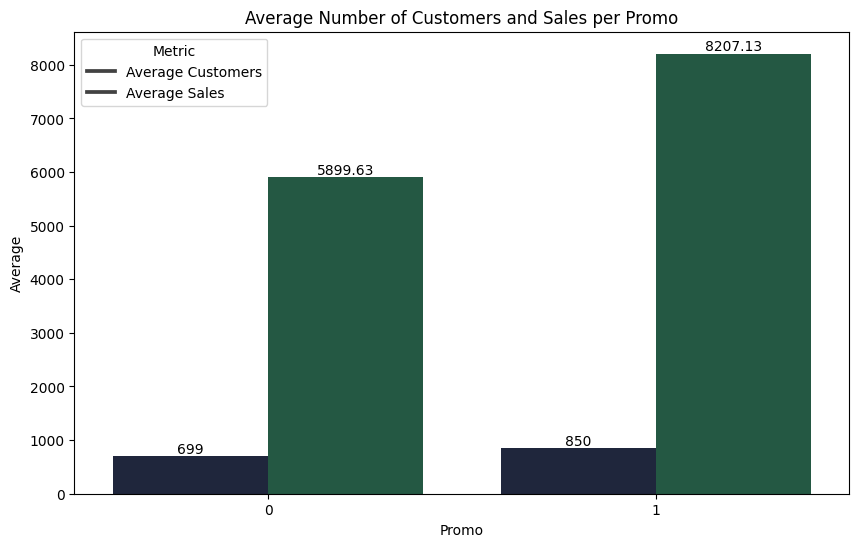

In [77]:
plt.figure(figsize=(10, 6))
sns.set_palette("cubehelix")
ax = sns.barplot(data=melted_promo, x='Promo', y='Average', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, label_type='edge')
plt.xlabel('Promo')
plt.ylabel('Average')
plt.title('Average Number of Customers and Sales per Promo')
plt.legend(title='Metric', loc='upper left', labels=['Average Customers', 'Average Sales'])
plt.show()

##### 3.5.4.2 Holiday

In [78]:
df_eda['StateHoliday'].value_counts()

0    535552
0    112140
a       501
b        96
c        71
Name: StateHoliday, dtype: int64

In [79]:
print(df_eda['StateHoliday'].unique())

['a' '0' 'b' 'c' 0]


In [80]:
df_eda['StateHoliday'] = df_eda['StateHoliday'].replace({0: '0'})

<ipython-input-80-cec1c906755e>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [81]:
StateHoliday_avg = pd.pivot_table(df_eda, index='StateHoliday', values=['Sales', 'Customers'], aggfunc='mean').reset_index()
StateHoliday_avg['Customers'] = StateHoliday_avg['Customers'].astype(int)
StateHoliday_avg

,StateHoliday,Customers,Sales
0,0,765,6913.677797
1,a,1261,8257.532934
2,b,1656,9566.145833
3,c,1569,9743.746479


In [82]:
melted_StateHoliday = pd.melt(StateHoliday_avg, id_vars='StateHoliday', var_name='Metric', value_name='Average')
melted_StateHoliday

,StateHoliday,Metric,Average
0,0,Customers,765.000000
1,a,Customers,1261.000000
2,b,Customers,1656.000000
3,c,Customers,1569.000000
4,0,Sales,6913.677797
5,a,Sales,8257.532934
6,b,Sales,9566.145833
7,c,Sales,9743.746479


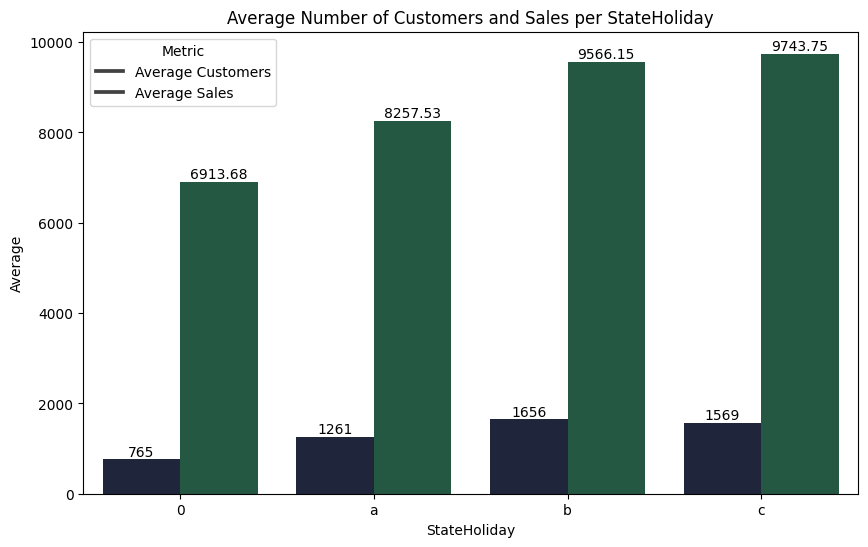

In [83]:
plt.figure(figsize=(10, 6))
sns.set_palette("cubehelix")
ax = sns.barplot(data=melted_StateHoliday, x='StateHoliday', y='Average', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, label_type='edge')
plt.xlabel('StateHoliday')
plt.ylabel('Average')
plt.title('Average Number of Customers and Sales per StateHoliday')
plt.legend(title='Metric', loc='upper left', labels=['Average Customers', 'Average Sales'])
plt.show()

#### 3.5.5 Type Of Store Comparison

In [84]:
col = df_eda.select_dtypes(include='object')

In [85]:
col

,StateHoliday,StoreType,Assortment,PromoInterval
0,a,b,b,"Feb,May,Aug,Nov"
1,a,b,b,0
2,a,b,b,"Jan,Apr,Jul,Oct"
3,a,b,a,0
4,a,b,b,"Mar,Jun,Sept,Dec"
...,...,...,...,...
648355,0,c,a,"Feb,May,Aug,Nov"
648356,0,a,c,"Jan,Apr,Jul,Oct"
648357,0,d,a,"Mar,Jun,Sept,Dec"
648358,0,a,c,0


In [86]:
col.drop('PromoInterval', axis = 1,inplace = True)

In [87]:
col = col.columns

In [88]:
for i in df_eda[col]:
  print(df_eda[i].value_counts())

0    647692
a       501
b        96
c        71
Name: StateHoliday, dtype: int64
a    351476
d    197846
c     87079
b     11959
Name: StoreType, dtype: int64
a    340968
c    301088
b      6304
Name: Assortment, dtype: int64


In [89]:
store_avg = pd.pivot_table(df_eda, index=['StoreType','Month'], values=['Sales','Customers','UPT'], aggfunc='mean').reset_index()

In [90]:
store_avg

,StoreType,Month,Customers,Sales,UPT
0,a,1,755.230873,6425.144903,8.624964
1,a,2,771.129357,6581.670123,8.668771
2,a,3,799.636023,6919.198130,8.770075
3,a,4,810.623473,6923.642864,8.677383
4,a,5,810.711856,6965.159422,8.761243
5,a,6,793.299997,6827.639004,8.758331
6,a,7,798.714593,6937.090677,8.825564
7,a,8,782.840621,6632.395297,8.640177
8,a,9,779.586749,6550.192769,8.517378
9,a,10,785.092830,6596.723266,8.561829


In [91]:
storea = store_avg.query('StoreType == "a" ')
storeb = store_avg.query('StoreType == "b" ')
storec = store_avg.query('StoreType == "c" ')
stored = store_avg.query('StoreType == "d" ')

In [92]:
fig = px.line(store_avg, x='Month', y='Sales', color='StoreType',
              markers=True, line_shape='linear', title='Sales Comparison between Store Types per Month')

fig.update_layout(xaxis_title='Month', yaxis_title='Average Sales', xaxis_dtick=1)

fig.show()
print('Store a Average Sales :',storea['Sales'].mean())
print('Store b Average Sales :',storeb['Sales'].mean())
print('Store c Average Sales :',storec['Sales'].mean())
print('Store d Average Sales :',stored['Sales'].mean())


Store a Average Sales : 6918.012208699209
Store b Average Sales : 10078.779396076701
Store c Average Sales : 6918.238544289783
Store d Average Sales : 6757.076263919025


In [93]:
fig = px.line(store_avg, x='Month', y='Customers', color='StoreType',
              markers=True, line_shape='linear', title='Customers Comparison between Store Types per Month')

fig.update_layout(xaxis_title='Month', yaxis_title='Average Customers', xaxis_dtick=1)

fig.show()
print('Store a Average Customers :',storea['Customers'].mean().round(0).astype(int))
print('Store b Average Customers :',storeb['Customers'].mean().round(0).astype(int))
print('Store c Average Customers :',storec['Customers'].mean().round(0).astype(int))
print('Store d Average Customers :',stored['Customers'].mean().round(0).astype(int))


Store a Average Customers : 801
Store b Average Customers : 2006
Store c Average Customers : 821
Store d Average Customers : 606


In [94]:
fig = px.line(store_avg, x='Month', y='UPT', color='StoreType',
              markers=True, line_shape='linear', title='UPT Comparison between Store Types per Month')

fig.update_layout(xaxis_title='Month', yaxis_title='Average UPT', xaxis_dtick=1)

fig.show()
print('Store a Average UPT :',storea['UPT'].mean().round(0).astype(int))
print('Store b Average UPT :',storeb['UPT'].mean().round(0).astype(int))
print('Store c Average UPT :',storec['UPT'].mean().round(0).astype(int))
print('Store d Average UPT :',stored['UPT'].mean().round(0).astype(int))

Store a Average UPT : 9
Store b Average UPT : 5
Store c Average UPT : 9
Store d Average UPT : 11


#### 3.5.6 Competitor Information

<Axes: >

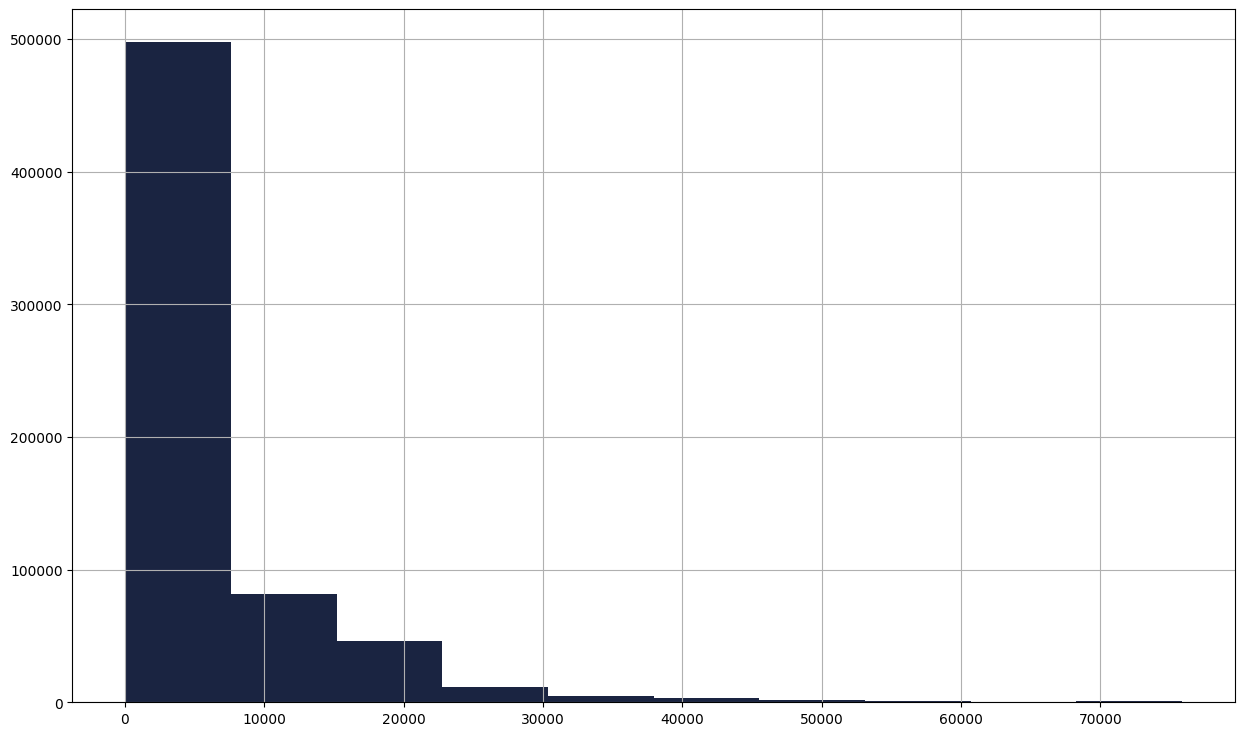

In [95]:
df_eda['CompetitionDistance'].hist(figsize=(15,9))

In [96]:
df_eda['CompetitionDistance'].describe()

count    648360.000000
mean       5465.305047
std        7816.438187
min          20.000000
25%         710.000000
50%        2330.000000
75%        6880.000000
max       75860.000000
Name: CompetitionDistance, dtype: float64

In [97]:
df_eda['CompetitionOpenSinceYear'].value_counts()

0       206344
2013     48404
2012     47305
2014     40524
2005     35911
2010     33018
2011     31793
2009     31262
2008     30714
2007     27734
2006     27240
2015     22184
2002     15970
2004     12509
2003     10518
2001      9354
2000      5883
1999      4779
1990      3012
1994      1204
1995      1054
1961       604
1998       592
1900       448
Name: CompetitionOpenSinceYear, dtype: int64

In [98]:
comp_st_avg  = pd.pivot_table(df_eda, index='StoreType', values=['Sales', 'Customers','CompetitionDistance', 'UPT'], aggfunc='mean').reset_index()

In [99]:
comp_as_avg  = pd.pivot_table(df_eda, index='Assortment', values=['Sales', 'Customers','CompetitionDistance', 'UPT'], aggfunc='mean').reset_index()

In [100]:
comp_avg  = pd.pivot_table(df_eda, index=['StoreType','Assortment'], values=['Sales', 'Customers','CompetitionDistance','UPT'], aggfunc='mean').reset_index()

In [101]:
comp_st_avg

,StoreType,CompetitionDistance,Customers,Sales,UPT
0,a,5240.019523,800.423722,6907.454424,8.761162
1,b,1076.127603,2006.557823,10082.926750,5.087215
2,c,3510.903662,819.823608,6907.847357,8.543438
3,d,6991.036907,605.409374,6741.437118,11.163430


In [102]:
comp_as_avg

,Assortment,CompetitionDistance,Customers,Sales,UPT
0,a,4394.568341,753.828644,6612.154296,9.042673
1,b,1192.815673,2024.510945,8360.192576,4.114372
2,c,6767.318830,752.934139,7228.601937,9.909299


In [103]:
comp_avg.sort_values(by='Sales', ascending = False)

,StoreType,Assortment,CompetitionDistance,Customers,Sales,UPT
4,b,c,1210.000000,3111.057534,17964.565753,5.745205
2,b,a,906.923858,1819.865178,11119.783553,6.234924
3,b,b,1192.815673,2024.510945,8360.192576,4.114372
1,a,c,7181.102500,859.024754,7529.822716,8.925663
6,c,c,4418.963718,790.464707,6988.477047,8.932725
8,d,c,7147.230554,616.001591,6931.637697,11.285460
5,c,a,2665.760720,847.148308,6832.804288,8.181123
0,a,a,4072.305838,765.170604,6533.051072,8.662201
7,d,a,6714.940029,586.685962,6405.227628,10.947723


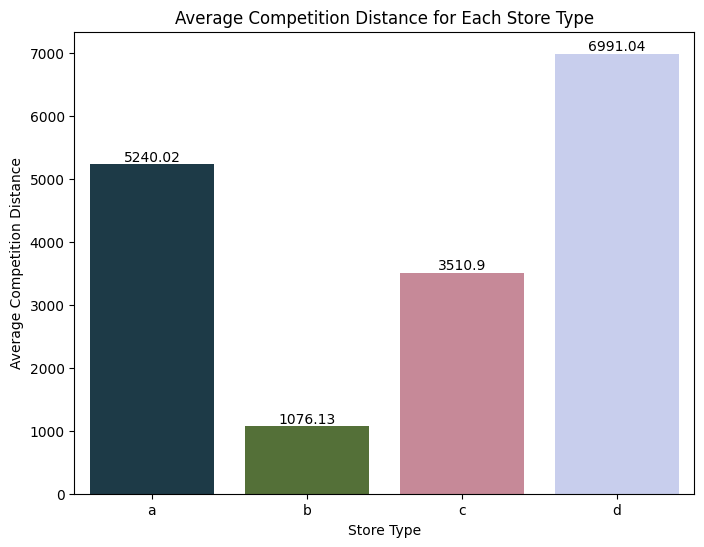

In [104]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=comp_st_avg.reset_index(), x='StoreType', y='CompetitionDistance', palette='cubehelix')
for container in ax.containers:
    ax.bar_label(container, label_type='edge')
plt.xlabel('Store Type')
plt.ylabel('Average Competition Distance')
plt.title('Average Competition Distance for Each Store Type')
plt.show()

In [105]:
avg_storepersales =df_eda.groupby('Store')[['Sales']].mean().reset_index()
avg_storepersales

,Store,Sales
0,1,4825.986799
1,2,4941.769737
2,3,6955.652318
3,4,9580.026316
4,5,4687.716418
...,...,...
1110,1111,5351.336093
1111,1112,10530.240066
1112,1113,6631.800987
1113,1114,20384.062500


In [106]:
fig = px.line(avg_storepersales, x='Store', y='Sales', title='Average Store Sales', markers=True)
fig.show()

## **4. Data PreProcessing**

### 4.1 Splitting Train and Test Set

In [107]:
train_size = int(len(df) * 0.8)

In [108]:
train = df[:train_size].copy(deep=True)
test = df[train_size:].copy(deep=True)

In [109]:
print(len(train))
print(len(test))

675513
168879


### 4.2 Preprocessing Function

In [110]:
catcol = train.select_dtypes(include='object')

In [111]:
catcol

,StateHoliday,StoreType,Assortment,PromoInterval
0,a,b,b,"Feb,May,Aug,Nov"
1,a,b,b,0
2,a,b,b,"Jan,Apr,Jul,Oct"
3,a,b,a,0
4,a,b,b,"Mar,Jun,Sept,Dec"
...,...,...,...,...
675508,0,a,c,"Jan,Apr,Jul,Oct"
675509,0,a,c,0
675510,0,a,c,0
675511,0,a,c,"Jan,Apr,Jul,Oct"


In [112]:
for x in catcol:
    print(f'Value In {x}: ', catcol[x].unique(), '\n', 'Total Value:', len(catcol[x].unique()))
    print('-'*100)

Value In StateHoliday:  ['a' '0' 'b' 'c' 0] 
 Total Value: 5
----------------------------------------------------------------------------------------------------
Value In StoreType:  ['b' 'a' 'd' 'c'] 
 Total Value: 4
----------------------------------------------------------------------------------------------------
Value In Assortment:  ['b' 'a' 'c'] 
 Total Value: 3
----------------------------------------------------------------------------------------------------
Value In PromoInterval:  ['Feb,May,Aug,Nov' 0 'Jan,Apr,Jul,Oct' 'Mar,Jun,Sept,Dec'] 
 Total Value: 4
----------------------------------------------------------------------------------------------------


In [113]:
def feature_engineering(data):
  alphabet = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
  monthlabel = {'0':0, 'Jan,Apr,Jul,Oct':1, 'Feb,May,Aug,Nov':2, 'Mar,Jun,Sept,Dec':3}
  data['StoreType'].replace(alphabet, inplace=True)
  data['Assortment'].replace(alphabet, inplace=True)
  data['StateHoliday'].replace(alphabet, inplace=True)
  data['PromoInterval'].replace(monthlabel, inplace=True)

  return data

In [114]:
feature_engineering(train).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675513 entries, 0 to 675512
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      675513 non-null  int64         
 1   DayOfWeek                  675513 non-null  int64         
 2   Date                       675513 non-null  datetime64[ns]
 3   Sales                      675513 non-null  int64         
 4   Customers                  675513 non-null  int64         
 5   Promo                      675513 non-null  int64         
 6   StateHoliday               675513 non-null  int64         
 7   SchoolHoliday              675513 non-null  int64         
 8   UPT                        675513 non-null  int64         
 9   Year                       675513 non-null  int64         
 10  Month                      675513 non-null  int64         
 11  Week                       675513 non-null  int64   

In [115]:
train.StoreType.unique()

array([2, 1, 4, 3])

In [116]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168879 entries, 675513 to 844391
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      168879 non-null  int64         
 1   DayOfWeek                  168879 non-null  int64         
 2   Date                       168879 non-null  datetime64[ns]
 3   Sales                      168879 non-null  int64         
 4   Customers                  168879 non-null  int64         
 5   Promo                      168879 non-null  int64         
 6   StateHoliday               168879 non-null  object        
 7   SchoolHoliday              168879 non-null  int64         
 8   UPT                        168879 non-null  int64         
 9   Year                       168879 non-null  int64         
 10  Month                      168879 non-null  int64         
 11  Week                       168879 non-null  int

In [117]:
feature_engineering(test).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168879 entries, 675513 to 844391
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      168879 non-null  int64         
 1   DayOfWeek                  168879 non-null  int64         
 2   Date                       168879 non-null  datetime64[ns]
 3   Sales                      168879 non-null  int64         
 4   Customers                  168879 non-null  int64         
 5   Promo                      168879 non-null  int64         
 6   StateHoliday               168879 non-null  int64         
 7   SchoolHoliday              168879 non-null  int64         
 8   UPT                        168879 non-null  int64         
 9   Year                       168879 non-null  int64         
 10  Month                      168879 non-null  int64         
 11  Week                       168879 non-null  int

### 4.3 Outliers

In [118]:
def calculate_outlier(data,col):
    Q3 = data[col].quantile(0.75)
    Q1 = data[col].quantile(0.25)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    lower_outliers = len(data[data[col] < lower])
    upper_outliers = len(data[data[col] > upper])
    percent_outliers = round(((data[data[col] > upper].shape[0]) + (data[data[col] < lower].shape[0])) / data.shape[0] * 100, 2)
    return lower, upper, percent_outliers, lower_outliers, upper_outliers

In [119]:
numcol = ['Sales', 'Customers', 'CompetitionDistance']
for i in numcol:
    lower_band, upper_band, percent_outliers,lower_outliers, upper_outliers = calculate_outlier(train, i)
    print(f'{i.upper()}:')
    print('Lower band = ' + str(lower_band))
    print('Upper band = ' + str(upper_band))
    print('Percentage of {0} that are outliers = {1:.2f}%'.format(i, percent_outliers))
    print(f'Total {i} Data: ', len(train[i]))
    print(f'Total {i} Uppers Outliers Data :', upper_outliers)
    print(f'Total {i} Lower Outliers Data :', lower_outliers)
    print('='*100)

SALES:
Lower band = -444.0
Upper band = 13572.0
Percentage of Sales that are outliers = 3.67%
Total Sales Data:  675513
Total Sales Uppers Outliers Data : 24820
Total Sales Lower Outliers Data : 0
CUSTOMERS:
Lower band = -49.0
Upper band = 1463.0
Percentage of Customers that are outliers = 4.86%
Total Customers Data:  675513
Total Customers Uppers Outliers Data : 32818
Total Customers Lower Outliers Data : 0
COMPETITIONDISTANCE:
Lower band = -8545.0
Upper band = 16135.0
Percentage of CompetitionDistance that are outliers = 9.84%
Total CompetitionDistance Data:  675513
Total CompetitionDistance Uppers Outliers Data : 66490
Total CompetitionDistance Lower Outliers Data : 0


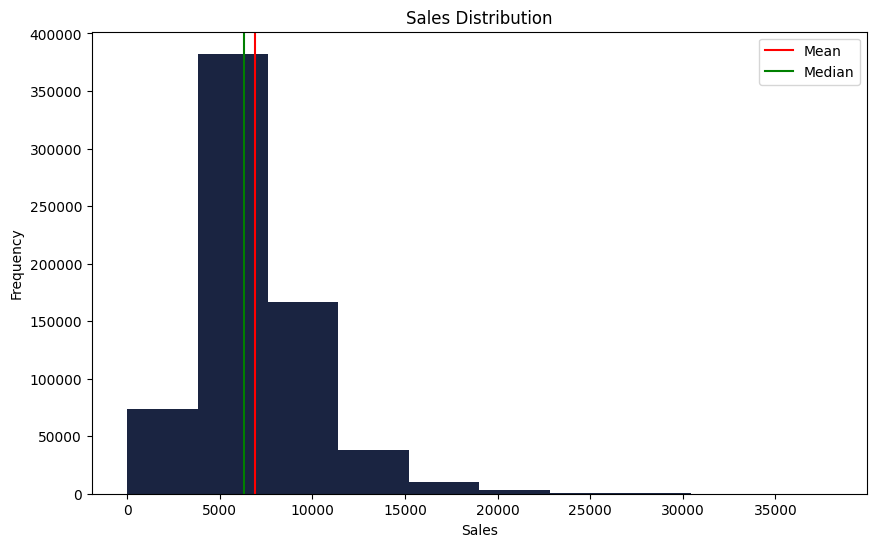

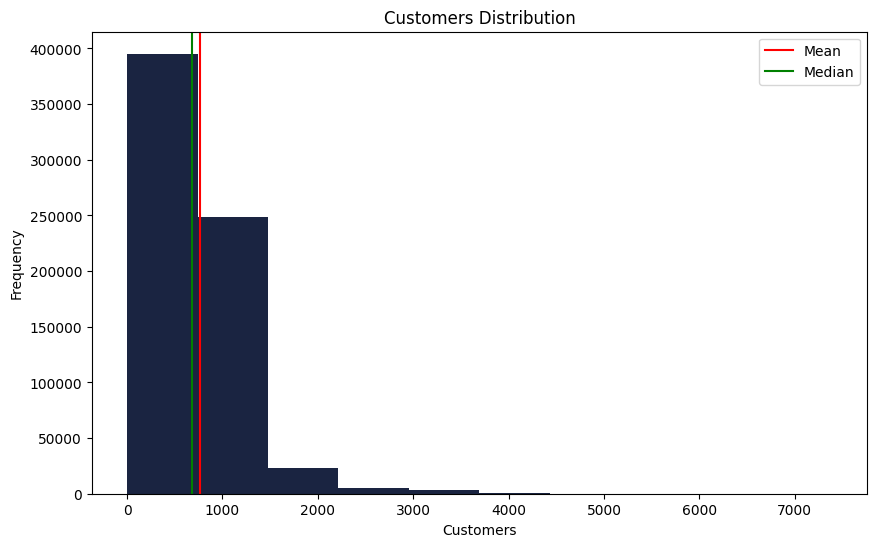

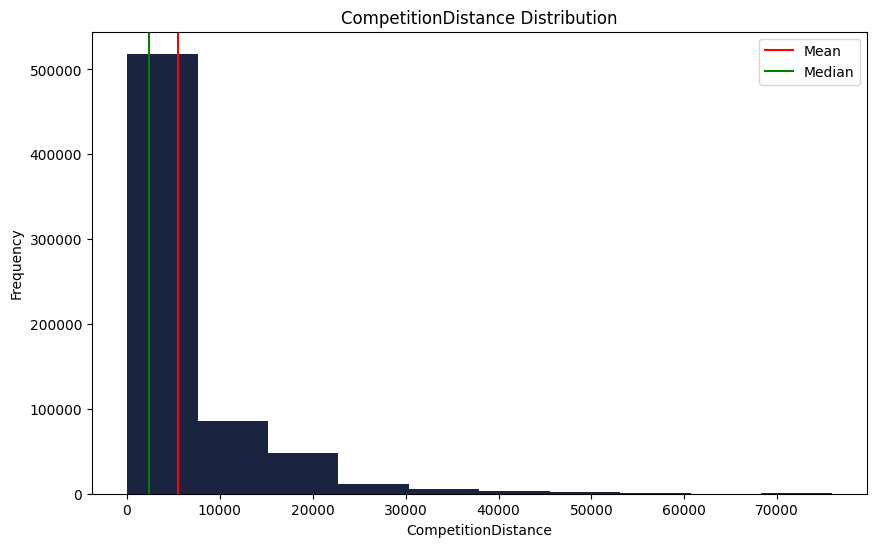

In [120]:
for i in numcol:
    # Assuming i contains the numerical column you want to plot
    plt.figure(figsize=(10, 6))

    # Plotting the histogram
    plt.hist(data=train, x=i)

    # Calculating mean and median
    mean_value = train[i].mean()
    median_value = train[i].median()

    # Adding vertical lines for mean and median
    plt.axvline(mean_value, color='red', linestyle='-', label='Mean')
    plt.axvline(median_value, color='green', linestyle='-', label='Median')

    # Adding labels, title, and legend
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.title(f'{i} Distribution')
    plt.legend()
    plt.show()




In [121]:
df_out = train[train['Sales']>13587]

In [122]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24704 entries, 3 to 675509
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      24704 non-null  int64         
 1   DayOfWeek                  24704 non-null  int64         
 2   Date                       24704 non-null  datetime64[ns]
 3   Sales                      24704 non-null  int64         
 4   Customers                  24704 non-null  int64         
 5   Promo                      24704 non-null  int64         
 6   StateHoliday               24704 non-null  int64         
 7   SchoolHoliday              24704 non-null  int64         
 8   UPT                        24704 non-null  int64         
 9   Year                       24704 non-null  int64         
 10  Month                      24704 non-null  int64         
 11  Week                       24704 non-null  int64         
 12  Day

In [123]:
outcol = ['Month','Promo','DayOfWeek','StateHoliday','SchoolHoliday','Promo2']

for i in df_out[outcol]:
  sorted = df_eda[i].value_counts().sort_index()
  sorted_out = df_out[i].value_counts().sort_index()
  print(f'[{i}]')
  print(sorted)
  print(f'[Outliers {i}]')
  print(sorted_out)
  print('='*100)



[Month]
1     57580
2     53476
3     56900
4     54800
5     54223
6     54153
7     55399
8     54413
9     52330
10    53292
11    51401
12    50393
Name: Month, dtype: int64
[Outliers Month]
1     2189
2     1467
3     2122
4     1882
5     1781
6     1829
7     1864
8     1524
9     1475
10    1364
11    1830
12    5377
Name: Month, dtype: int64
[Promo]
0    362944
1    285416
Name: Promo, dtype: int64
[Outliers Promo]
0     6923
1    17781
Name: Promo, dtype: int64
[DayOfWeek]
1    106330
2    110846
3    108519
4    102972
5    106292
6    110630
7      2771
Name: DayOfWeek, dtype: int64
[Outliers DayOfWeek]
1    8933
2    4201
3    2868
4    2744
5    3194
6    2322
7     442
Name: DayOfWeek, dtype: int64
[StateHoliday]
0    647692
a       501
b        96
c        71
Name: StateHoliday, dtype: int64
[Outliers StateHoliday]
0    24599
1       71
2       21
3       13
Name: StateHoliday, dtype: int64
[SchoolHoliday]
0    516486
1    131874
Name: SchoolHoliday, dtype: int64
[Outli

In [124]:
train_final = train.copy(deep=True)

In [125]:
train_final['Sales'] = np.where(train_final['Sales']>13587, 13587, train_final['Sales'])
train_final[train_final['Sales']>13587]

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,UPT,Year,...,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


In [126]:
sales_corr = train_final.corr()['Sales']
sales_corr.sort_values(ascending = False)

<ipython-input-126-86dbf2345478>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Sales                        1.000000
Customers                    0.778906
Promo                        0.395895
UPT                          0.209021
Assortment                   0.104518
Week                         0.088300
Month                        0.087651
Year                         0.032584
SchoolHoliday                0.031006
StateHoliday                 0.011785
CompetitionOpenSinceYear     0.011689
Store                        0.007156
StoreType                   -0.009481
CompetitionOpenSinceMonth   -0.011457
CompetitionDistance         -0.028369
Promo2SinceWeek             -0.053260
Day                         -0.059112
Promo2                      -0.123476
Promo2SinceYear             -0.123507
PromoInterval               -0.128967
DayOfWeek                   -0.188976
Name: Sales, dtype: float64

## **5. Model (Prophet)**

### 5.1 Holiday Seasonality

In [127]:
school_holiday = train_final[train_final['SchoolHoliday'] == 1]['Date'].unique()

In [128]:
school_holiday.sort()

In [129]:
public_holiday = train_final[train_final['StateHoliday'] == 1]['Date'].unique()
public_holiday.sort()

In [130]:
easter_holiday = train_final[train_final['StateHoliday'] == 2]['Date'].unique()
easter_holiday.sort()

In [131]:
christmas_holiday = train_final[train_final['StateHoliday'] == 3]['Date'].unique()
christmas_holiday.sort()

In [132]:
df_school = pd.DataFrame({'ds': school_holiday, 'holiday':'school_holiday'})
df_public = pd.DataFrame({'ds': public_holiday, 'holiday':'public_holiday'})
df_easter = pd.DataFrame({'ds': easter_holiday, 'holiday':'easter_holiday'})
df_christmas = pd.DataFrame({'ds': christmas_holiday, 'holiday':'chrtistmas_holiday'})

df_holiday = pd.concat((df_school, df_public, df_easter, df_christmas))

In [133]:
df_holiday

,ds,holiday
0,2013-01-01,school_holiday
1,2013-01-02,school_holiday
2,2013-01-03,school_holiday
3,2013-01-04,school_holiday
4,2013-01-05,school_holiday
...,...,...
3,2014-04-21,easter_holiday
0,2013-12-25,chrtistmas_holiday
1,2013-12-26,chrtistmas_holiday
2,2014-12-25,chrtistmas_holiday


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844392 entries, 0 to 844391
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Promo                      844392 non-null  int64         
 6   StateHoliday               844392 non-null  object        
 7   SchoolHoliday              844392 non-null  int64         
 8   UPT                        844392 non-null  int64         
 9   Year                       844392 non-null  int64         
 10  Month                      844392 non-null  int64         
 11  Week                       844392 non-null  int64   

### 5.2 Model Definition

In [135]:
model = Prophet(holidays=df_holiday)
regressors = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day', 'StoreType', 'Assortment']

for regressor in regressors:
    model.add_regressor(regressor)

### 5.3 Prophet Data Function

In [136]:
def preparedata(data, storeid, Type="train"):
    newdata = data.copy(deep=True)
    newdata = data[data['Store']==storeid]
    newdata.rename({"Sales": "y", "Date" : "ds"},axis=1, inplace = True)
    newdata = newdata[['Store', 'ds', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day', 'StoreType', 'Assortment', 'y']]
    if Type == "test":
        newdata.drop("y", axis=1, inplace=True)
    return newdata

In [137]:
train_data = preparedata(train_final, 3)
test_data = preparedata(test, 3, Type='test')

<ipython-input-136-2b0f43b72c78>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-136-2b0f43b72c78>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 5.4 RMPSE (Root Mean Percentage Squared Error) Function

In [138]:
def rmspe(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)

### 5.5 Model Training and Evaluation

In [139]:
model.fit(train_data)
test_data_predictions = model.predict(test_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/cbnmt9__.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/xvfn91op.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29914', 'data', 'file=/tmp/tmpex2s9fz3/cbnmt9__.json', 'init=/tmp/tmpex2s9fz3/xvfn91op.json', 'output', 'file=/tmp/tmpex2s9fz3/prophet_model5sbp8ld1/prophet_model-20230728213220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:32:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [140]:
test_data_predictions.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assortment,Assortment_lower,Assortment_upper,Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-31,6555.953045,2655.562261,5169.679635,6555.953045,6555.953045,-128.400547,-128.400547,-128.400547,10.547157,...,-415.504434,-415.504434,-415.504434,-183.151723,-183.151723,-183.151723,0.0,0.0,0.0,3952.728017


In [141]:
actual_sales_data = test[test['Store'] == 3]['Sales'].round(0).astype(int)
predicted_sales_data = test_data_predictions['yhat'].round(0).astype(int)
rmspe_value = rmspe(actual_sales_data, predicted_sales_data)
mae = mean_absolute_error(actual_sales_data, predicted_sales_data)
r2 = r2_score(actual_sales_data,predicted_sales_data)
print("MAE:", mae)
print("RMSPE:", rmspe_value)

MAE: 899.2066666666667
RMSPE: 0.16934541908134687


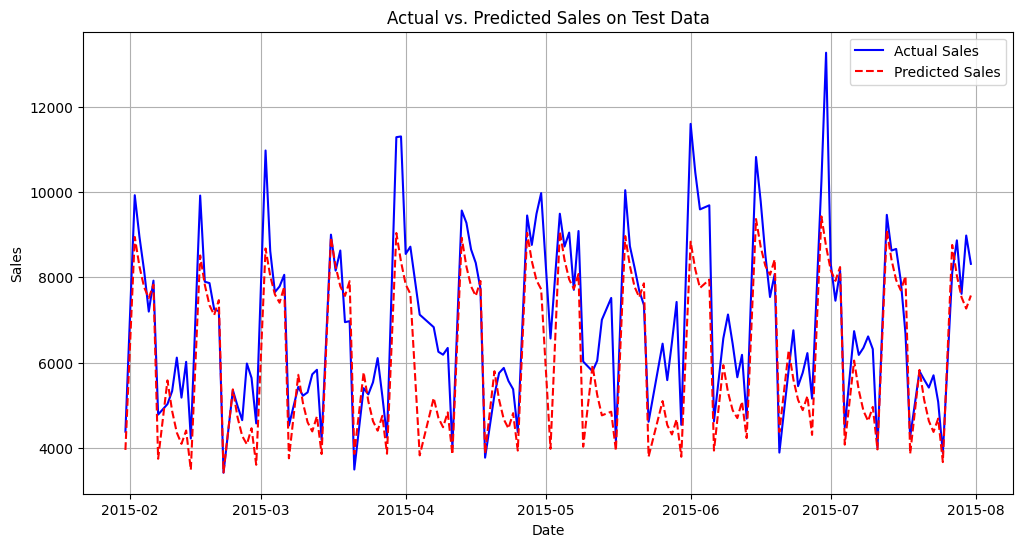

In [142]:
plt.figure(figsize=(12, 6))
plt.plot(test_data['ds'], actual_sales_data, label='Actual Sales', color='blue')
plt.plot(test_data['ds'], predicted_sales_data, label='Predicted Sales', linestyle='dashed', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Sales on Test Data')
plt.legend()
plt.grid(True)
plt.show()

In [143]:
# Create the Plotly figure
fig = go.Figure()

# Add the actual sales trace
fig.add_trace(go.Scatter(x=test_data['ds'], y=actual_sales_data, mode='lines', name='Actual Sales', line=dict(color='blue')))

# Add the predicted sales trace
fig.add_trace(go.Scatter(x=test_data['ds'], y=predicted_sales_data, mode='lines', name='Predicted Sales', line=dict(color='red', dash='dash')))

# Update the layout of the figure
fig.update_layout(
    title='Actual vs. Predicted Sales on Test Data',
    xaxis_title='Date',
    yaxis_title='Sales',
    showlegend=True
)

# Show the plot
fig.show()


### 5.6 HyperParameter Tuning

In [144]:
train_tuning = preparedata(train_final,3)

test_tuning = preparedata(test,3)
regressors = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day', 'StoreType', 'Assortment']

parameters = {'changepoint_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
              'seasonality_prior_scale': [0.01, 0.1, 1.0],
              'holidays_prior_scale': [0.1,0.2,0.3,0.4,0.5],
              'seasonality_mode': ['additive', 'multiplicative'],
              'changepoint_range': [0.8, 0.9, 1.0],
              'daily_seasonality': [True,False],
              'weekly_seasonality': [True,False],
              'yearly_seasonality': [True,False]}
best_model = None
best_param = None
best_rmspe = float('inf')

<ipython-input-136-2b0f43b72c78>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-136-2b0f43b72c78>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [145]:
for params in tqdm(ParameterGrid(parameters)):
    model = Prophet(holidays=df_holiday,**params)
    for i in regressors:
      model.add_regressor(i)
    model.fit(train_tuning)
    test_predictions = model.predict(test_tuning)
    actual_sales = test[test['Store'] == 3]['Sales'].round(0).astype(int)
    predicted_sales = test_predictions['yhat'].round(0).astype(int)
    rmspe_score = rmspe(predicted_sales, actual_sales)

    if rmspe_score < best_rmspe:
        best_rmspe = rmspe_score
        print(f"  Found new best RMSPE: {best_rmspe}")
        best_model = model
        best_param = params

  0%|          | 0/3600 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/df7at1b_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/ihxby2m1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13002', 'data', 'file=/tmp/tmpex2s9fz3/df7at1b_.json', 'init=/tmp/tmpex2s9fz3/ihxby2m1.json', 'output', 'file=/tmp/tmpex2s9fz3/prophet_models4_g7lh1/prophet_model-20230728213221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:32:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 1/3600 [00:00<27:31,  2.18it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/vt1gygxm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/yhz8miuk.json
DEBUG:cmdstanpy:idx 0
DEBUG:

  Found new best RMSPE: 0.18762828600562603


21:32:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 2/3600 [00:00<28:17,  2.12it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/nq7vyut0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/axp927r4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31880', 'data', 'file=/tmp/tmpex2s9fz3/nq7vyut0.json', 'init=/tmp/tmpex2s9fz3/axp927r4.json', 'output', 'file=/tmp/tmpex2s9fz3/prophet_modellajk3nq_/prophet_model-20230728213222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


  Found new best RMSPE: 0.135207287270467


21:32:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 3/3600 [00:01<28:43,  2.09it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/il8vhlp_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/1yj9ua2m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36384', 'data', 'file=/tmp/tmpex2s9fz3/il8vhlp_.json', 'init=/tmp/tmpex2s9fz3/1yj9ua2m.json', 'output', 'file=/tmp/tmpex2s9fz3/prophet_modelqy29lgxn/prophet_model-20230728213222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:32:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 4/3600 [00:01<30:54,  1.94it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/

  Found new best RMSPE: 0.13516282307199226


21:32:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 11/3600 [00:05<31:22,  1.91it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/zchuc6uu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/y16_a6vb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61510', 'data', 'file=/tmp/tmpex2s9fz3/zchuc6uu.json', 'init=/tmp/tmpex2s9fz3/y16_a6vb.json', 'output', 'file=/tmp/tmpex2s9fz3/prophet_modelxios_0m2/prophet_model-20230728213227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:32:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 12/3600 [00:06<35:27,  1.69it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz

  Found new best RMSPE: 0.13508853644214944


21:32:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  1%|          | 27/3600 [00:15<29:04,  2.05it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/exdi2tg4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/55r75izm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10096', 'data', 'file=/tmp/tmpex2s9fz3/exdi2tg4.json', 'init=/tmp/tmpex2s9fz3/55r75izm.json', 'output', 'file=/tmp/tmpex2s9fz3/prophet_modelfe4a7195/prophet_model-20230728213236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:32:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  1%|          | 28/3600 [00:15<28:02,  2.12it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz

  Found new best RMSPE: 0.13474344316834816


21:32:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  1%|          | 35/3600 [00:19<29:44,  2.00it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/g315rc36.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/d3vseehm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62160', 'data', 'file=/tmp/tmpex2s9fz3/g315rc36.json', 'init=/tmp/tmpex2s9fz3/d3vseehm.json', 'output', 'file=/tmp/tmpex2s9fz3/prophet_modeldwiyh0z5/prophet_model-20230728213240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  1%|          | 36/3600 [00:19<29:23,  2.02it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz

  Found new best RMSPE: 0.13430693200366386


Streaming output truncated to the last 5000 lines.
INFO:cmdstanpy:Chain [1] start processing
22:07:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
 85%|████████▍ | 3045/3600 [35:22<07:26,  1.24it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/2xozh17q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/lmm57a3h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31065', 'data', 'file=/tmp/tmpex2s9fz3/2xozh17q.json', 'init=/tmp/tmpex2s9fz3/lmm57a3h.json', 'output', 'file=/tmp/tmpex2s9fz3/prophet_modelg5yw2c5t/prophet_model-20230728220743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:07:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:07:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
 

In [175]:
print(f"Best RMSPE: {best_rmspe}")
print(f"Best Params: {best_param}")

Best RMSPE: 0.13430693200366386
Best Params: {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'daily_seasonality': False, 'holidays_prior_scale': 0.2, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'weekly_seasonality': True, 'yearly_seasonality': False}


### 5.7 Final Model Function

In [146]:
def prophetfunction(train, test, store_id):
    # Create a new instance of the Prophet model
    model = Prophet(changepoint_prior_scale = 0.1, changepoint_range = 0.8, daily_seasonality = False, holidays_prior_scale = 0.2, seasonality_mode = 'additive', seasonality_prior_scale = 0.01, weekly_seasonality = True, yearly_seasonality = False)

    # Add regressors if needed
    regressors = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day', 'StoreType', 'Assortment']
    for regressor in regressors:
        model.add_regressor(regressor)

    # Prepare the data for the given store
    newtest = test.copy(deep= True)
    train_prophet = preparedata(train, store_id)
    test_prophet = preparedata(newtest, store_id, Type='test')

    # Fit the model on the data for the given store
    model.fit(train_prophet)

    # Make predictions for the given store
    predictions = model.predict(test_prophet)

    actual_sales_prophet = newtest[newtest['Store'] == store_id]['Sales'].round(0).astype(int)
    predicted_sales_prophet = predictions['yhat'].round(0).astype(int)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_prophet['ds'], y=actual_sales_prophet, mode='lines', name='Actual Sales', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=test_prophet['ds'], y=predicted_sales_prophet, mode='lines', name='Predicted Sales', line=dict(color='red', dash='dash')))
    fig.update_layout(
        title='Actual vs. Predicted Sales on Test Data',
        xaxis_title='Date',
        yaxis_title='Sales',
        showlegend=True
    )
    fig.show()
    rmspe_value = rmspe(actual_sales_prophet, predicted_sales_prophet)
    mae = mean_absolute_error(actual_sales_prophet, predicted_sales_prophet)

    print("MAE:", mae)
    print("RMSPE:", rmspe_value)

In [147]:
prophetfunction(train_final, test, 3)

<ipython-input-136-2b0f43b72c78>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-136-2b0f43b72c78>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/c1l0gxva.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/wvyza2aw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33034', 'data', 'file=/tmp/tmpex2s9fz3/c1l0gxva.json', 'init=/tmp/tmpex2s9fz3/wvyza2aw.json', 'output', 'file=/tmp/tmpex2s9fz3/prophet_m

MAE: 702.4933333333333
RMSPE: 0.13276985797245935


### 5.8 Forecasting

#### 5.8.1 Without Test Data

In [148]:
def futureforecast(data, store_id, period):
  if not (1 <= period <= 150):
        raise ValueError("The 'period' argument must be in the range of 1 to 150.")
  model= Prophet(changepoint_prior_scale = 0.1, changepoint_range = 0.8, daily_seasonality = False, holidays_prior_scale = 0.2, seasonality_mode = 'additive', seasonality_prior_scale = 0.01, weekly_seasonality = True, yearly_seasonality = False)

  regressors = ['DayOfWeek', 'Year', 'Month', 'Week', 'Day']
  for regressor in regressors:
    model.add_regressor(regressor)

  historical_sales = feature_engineering(data)
  historical_sales = preparedata(data, store_id)

  last_date = df['Date'].iloc[-1]

  df_future = pd.DataFrame({
      'ds': pd.date_range(start=last_date + pd.Timedelta(days=1), end=last_date + pd.Timedelta(days=period), freq='D')
  })

  df_future['DayOfWeek'] = df_future['ds'].dt.dayofweek.replace(0,7)
  df_future['Year'] = pd.DatetimeIndex(df_future['ds']).year
  df_future['Month'] = pd.DatetimeIndex(df_future['ds']).month
  df_future['Week'] = pd.DatetimeIndex(df_future['ds']).week
  df_future['Day'] = pd.DatetimeIndex(df_future['ds']).day

  model.fit(historical_sales)
  predictions = model.predict(df_future)

  actual_sales_forecast = historical_sales['y'].round(0).astype(int)
  predicted_sales_forecast = predictions['yhat'].round(0).astype(int)

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=historical_sales['ds'], y=actual_sales_forecast, mode='lines', name='Actual Sales', line=dict(color='blue')))
  fig.add_trace(go.Scatter(x=predictions['ds'], y=predicted_sales_forecast, mode='lines', name='Predicted Sales', line=dict(color='red')))
  fig.update_layout(
        xaxis_title='Date',
        yaxis_title='Sales',
        showlegend=True
    )
  fig.show()

  return predictions[['ds','yhat']]

In [149]:
ff = futureforecast(df, 3, 47)

<ipython-input-136-2b0f43b72c78>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-148-ac1b5d5b3c77>:22: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/7meg2hz4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/d3bo80hr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40925', 'data', 'file=/tmp/tmpex2s9fz3/7meg2hz4.json', 'init=/tmp/tmpex2s9fz3/d3bo80hr.json', 'output',

#### 5.8.2 With  Test Data

In [150]:
df_test = pd.read_csv('/content/drive/My Drive/Real_Case_Project/Dataset/test.csv')

In [151]:
df_test = df_test.sort_values(by='Date')

In [152]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 41087 to 0
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.8+ MB


In [153]:
df_test = df_test.query("Open == 1")
df_test.drop('Open', axis = 1 , inplace = True)

In [154]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35093 entries, 41087 to 0
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             35093 non-null  int64 
 1   Store          35093 non-null  int64 
 2   DayOfWeek      35093 non-null  int64 
 3   Date           35093 non-null  object
 4   Promo          35093 non-null  int64 
 5   StateHoliday   35093 non-null  object
 6   SchoolHoliday  35093 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 2.1+ MB


In [155]:
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test['Year'] = pd.DatetimeIndex(df_test['Date']).year
df_test['Month'] = pd.DatetimeIndex(df_test['Date']).month
df_test['Week'] = pd.DatetimeIndex(df_test['Date']).week
df_test['Day'] = pd.DatetimeIndex(df_test['Date']).day

<ipython-input-155-d7703b2d291c>:4: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



In [156]:
df_test = pd.merge(df_test, store, how='inner', on = 'Store')

In [157]:
df_test['DayOfWeek'] = df_test['Date'].dt.dayofweek.replace(0,7)

In [158]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35093 entries, 0 to 35092
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         35093 non-null  int64         
 1   Store                      35093 non-null  int64         
 2   DayOfWeek                  35093 non-null  int64         
 3   Date                       35093 non-null  datetime64[ns]
 4   Promo                      35093 non-null  int64         
 5   StateHoliday               35093 non-null  object        
 6   SchoolHoliday              35093 non-null  int64         
 7   Year                       35093 non-null  int64         
 8   Month                      35093 non-null  int64         
 9   Week                       35093 non-null  int64         
 10  Day                        35093 non-null  int64         
 11  StoreType                  35093 non-null  object        
 12  Asso

In [159]:
feature_engineering(df_test)

,Id,Store,DayOfWeek,Date,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,41088,1115,5,2015-08-01,0,0,1,2015,8,31,1,4,3,5350,0,0,1,22,2012,3
1,39376,1115,7,2015-08-03,1,0,1,2015,8,32,3,4,3,5350,0,0,1,22,2012,3
2,38520,1115,1,2015-08-04,1,0,1,2015,8,32,4,4,3,5350,0,0,1,22,2012,3
3,37664,1115,2,2015-08-05,1,0,1,2015,8,32,5,4,3,5350,0,0,1,22,2012,3
4,36808,1115,3,2015-08-06,1,0,1,2015,8,32,6,4,3,5350,0,0,1,22,2012,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35088,4849,734,5,2015-09-12,0,0,0,2015,9,37,12,1,1,220,0,0,1,36,2013,3
35089,3137,734,7,2015-09-14,1,0,0,2015,9,38,14,1,1,220,0,0,1,36,2013,3
35090,2281,734,1,2015-09-15,1,0,0,2015,9,38,15,1,1,220,0,0,1,36,2013,3
35091,1425,734,2,2015-09-16,1,0,0,2015,9,38,16,1,1,220,0,0,1,36,2013,3


In [160]:
def prepare_df_prophet_test(df, storeid):
    newdf = df.copy(deep=True)
    newdf = df[df['Store']==storeid]
    newdf.rename({ "Date" : "ds"},axis=1, inplace = True)
    newdf = newdf[['Store', 'ds', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day', 'StoreType', 'Assortment']]
    return newdf

In [161]:
df_test_prophet = prepare_df_prophet_test(df_test, 3)

<ipython-input-160-f06b761d359e>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [162]:
df_test_prophet.head(1)

,Store,ds,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,StoreType,Assortment
11868,3,2015-08-01,5,0,0,0,2015,8,31,1,1,1


In [163]:
model_test = Prophet(holidays=df_holiday,changepoint_prior_scale = 0.5, changepoint_range = 1.0, holidays_prior_scale = 0.3, seasonality_prior_scale = 0.01)
regressors_test = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day', 'StoreType', 'Assortment']

for regressor in regressors_test:
    model_test.add_regressor(regressor)

In [164]:
historical_sales_train = feature_engineering(df)
historical_sales_train = preparedata(df, 3)

<ipython-input-136-2b0f43b72c78>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [165]:
model_test.fit(historical_sales_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/t6sq9ajx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/5yqr5s4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16129', 'data', 'file=/tmp/tmpex2s9fz3/t6sq9ajx.json', 'init=/tmp/tmpex2s9fz3/5yqr5s4s.json', 'output', 'file=/tmp/tmpex2s9fz3/prophet_modeld0t7fhv_/prophet_model-20230728221444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:14:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [166]:
predictions_test = model.predict(df_test_prophet)

In [167]:
actual_sales = historical_sales_train['y'].round(0).astype(int)
predicted_sales = predictions_test['yhat'].round(0).astype(int)

In [168]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=historical_sales_train['ds'], y=actual_sales, mode='lines', name='Actual Sales', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=predictions_test['ds'], y=predicted_sales, mode='lines', name='Predicted Sales', line=dict(color='red')))
fig.update_layout(
        xaxis_title='Date',
        yaxis_title='Sales',
        showlegend=True
    )
fig.show()

##### 5.8.2.1 Final Function

In [169]:
df_test_prophet = pd.read_csv('/content/drive/My Drive/Real_Case_Project/Dataset/test.csv')
df_test_prophet = df_test_prophet.sort_values(by='Date')
df_test_prophet = df_test_prophet.query("Open == 1")
df_test_prophet.drop('Open', axis = 1 , inplace = True)
df_test_prophet['Date'] = pd.to_datetime(df_test_prophet['Date'])
df_test_prophet['Year'] = pd.DatetimeIndex(df_test_prophet['Date']).year
df_test_prophet['Month'] = pd.DatetimeIndex(df_test_prophet['Date']).month
df_test_prophet['Week'] = pd.DatetimeIndex(df_test_prophet['Date']).week
df_test_prophet['Day'] = pd.DatetimeIndex(df_test_prophet['Date']).day
df_test_prophet = pd.merge(df_test_prophet, store, how='inner', on = 'Store')
df_test_prophet['DayOfWeek'] = df_test_prophet['Date'].dt.dayofweek.replace(0,7)
df_test_prophet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35093 entries, 0 to 35092
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         35093 non-null  int64         
 1   Store                      35093 non-null  int64         
 2   DayOfWeek                  35093 non-null  int64         
 3   Date                       35093 non-null  datetime64[ns]
 4   Promo                      35093 non-null  int64         
 5   StateHoliday               35093 non-null  object        
 6   SchoolHoliday              35093 non-null  int64         
 7   Year                       35093 non-null  int64         
 8   Month                      35093 non-null  int64         
 9   Week                       35093 non-null  int64         
 10  Day                        35093 non-null  int64         
 11  StoreType                  35093 non-null  object        
 12  Asso

<ipython-input-169-37261f0274cc>:8: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



In [170]:
def prepare_df_test(test, storeid):
    newtest = test.copy(deep=True)
    newtest = test[test['Store']==storeid]
    newtest.rename({ "Date" : "ds"},axis=1, inplace = True)
    newtest = newtest[['Store', 'ds', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day', 'StoreType', 'Assortment']]
    return newtest


In [171]:
def forecast_test(train,test,store_id):
  newdf= test.copy(deep=True)
  feature_engineering(newdf)

  df_test_prophet = prepare_df_prophet_test(newdf, store_id)
  model_test = Prophet(changepoint_prior_scale = 0.1, changepoint_range = 0.8, daily_seasonality = False, holidays_prior_scale = 0.2, seasonality_mode = 'additive', seasonality_prior_scale = 0.01, weekly_seasonality = True, yearly_seasonality = False)
  regressors_test = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day', 'StoreType', 'Assortment']

  for i in regressors_test:
      model_test.add_regressor(i)

  historical_sales_train = feature_engineering(train)
  historical_sales_train = preparedata(train, store_id)

  model_test.fit(historical_sales_train)
  predictions_test = model_test.predict(df_test_prophet)

  actual_sales = historical_sales_train['y'].round(0).astype(int)
  predicted_sales = predictions_test['yhat'].round(0).astype(int)

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=historical_sales_train['ds'], y=actual_sales, mode='lines', name='Actual Sales', line=dict(color='blue')))
  fig.add_trace(go.Scatter(x=predictions_test['ds'], y=predicted_sales, mode='lines', name='Predicted Sales', line=dict(color='red')))
  fig.update_layout(
          xaxis_title='Date',
          yaxis_title='Sales',
          showlegend=True
      )
  fig.show()


In [172]:
forecast_test(df,df_test_prophet,25)

<ipython-input-160-f06b761d359e>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-136-2b0f43b72c78>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/td1v8hok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpex2s9fz3/ztdo5207.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98518', 'data', 'file=/tmp/tmpex2s9fz3/td1v8hok.json', 'init=/tmp/tmpex2s9fz3/ztdo5207.json', 'output', 'file=/tmp/tmpex2s9fz3/prophet_m